# Quantum Machine Learning for Join Ordering

This notebook will demonstrate a simple example of using a variational quantum circuit (VQC) in machine learning for join order optimization.


## Imports

In [1]:
from math import pi
import csv
from collections import deque
import random
import numpy as np

# Qiskit Circuit imports
from qiskit.circuit import QuantumCircuit, QuantumRegister, Parameter, ParameterVector, ParameterExpression

# Qiskit imports
import qiskit as qk
from qiskit.utils import QuantumInstance
from qiskit import Aer
from qiskit.visualization import plot_histogram

# Qiskit Machine Learning imports
from qiskit_machine_learning.neural_networks import CircuitQNN
from qiskit_machine_learning.connectors import TorchConnector

# PyTorch imports
import torch
from torch import Tensor
from torch.optim import Adam

# Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline

## Create the Variational Quantum Circuit (VQC)

### Circuit Hyperparameters

In [2]:
num_qubits = 4  # Number of qubits
num_layers = 8  # Number of variational layers in the circuit

### Encoding Layer (Quantum!)

In [3]:
# Create a quantum circuit
qc = qk.QuantumCircuit(num_qubits)

# Parameters for input
x = qk.circuit.ParameterVector('x', num_qubits)

# Add encoding layer
for i in range(num_qubits):
    qc.rx(x[i], i)


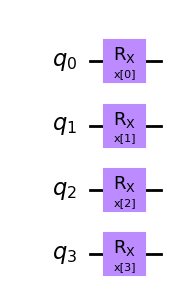

In [4]:
# Draw the circuit 
qc.draw("mpl")

### Variational Layers (Quantum!)

In [5]:
# Parameters for variational layers
thetas = [ qk.circuit.ParameterVector(f'th{l}_', 2*num_qubits) for l in range(num_layers) ] 

# Add variational layers
for l in range(num_layers):
    qc.barrier() # for nicer visualisation
    
    # Variational part
    for i in range(num_qubits):
        qc.ry(thetas[l][2*i], i)
        qc.rz(thetas[l][2*i+1], i)
    
    # Entangling part
    for i in range(num_qubits-1):
        qc.cx(i, i+1)


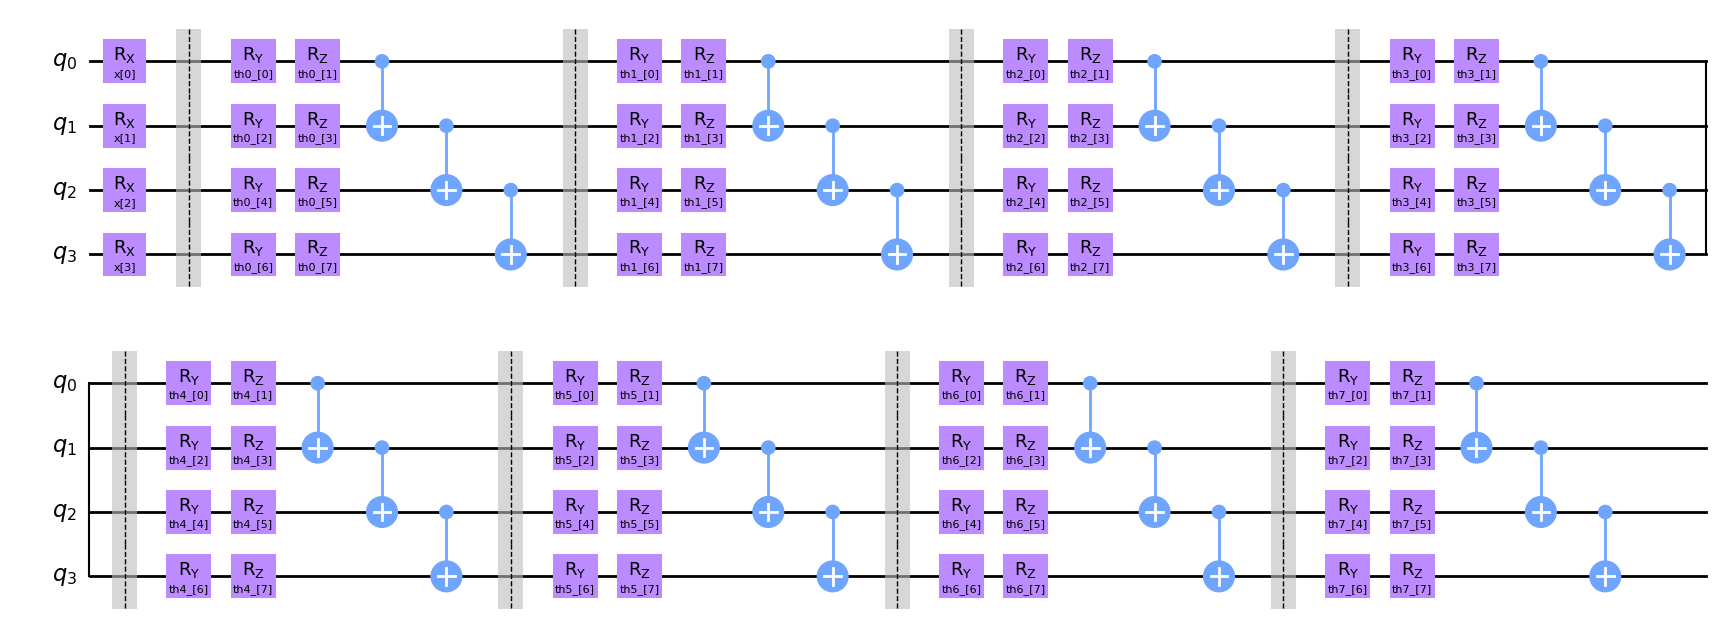

In [6]:
# Draw the circuit 
qc.draw("mpl")

### Example: Measure circuit (Quantum!)

In [7]:
# Extract the parameters to optimize
params = list(qc.parameters)[:-num_qubits]
num_params = len(params)

# Generate dummy input
num_inputs = len(x)
dummy_inputs = np.zeros(num_inputs)

# Generate variational parameters randomly in [-pi,pi] 
example_param_values = (2*pi*np.random.rand(num_params) - pi)
print(example_param_values)

[-0.13570251  1.92610023  1.41112145 -0.8491586   1.92909119 -1.62579211
 -0.99172644  1.6727482   1.09280488 -1.3812335  -2.87477476 -1.59740163
  2.25288844  0.47308786 -2.25278103 -3.06017026  2.02938732  2.22004289
  2.24131679  1.36817673  3.06616975 -2.08079145  1.03450525 -2.71540454
  1.76964382  0.58279814  0.64007988 -2.72119447  2.21511064 -1.53704251
 -0.23379808 -1.68049603 -0.03866472  0.74187951 -1.84603206  1.09653673
 -1.87477367  2.95029729 -0.43330892 -1.88406514  3.03947709 -0.32317549
  0.66586455  1.88254628 -1.21413618  0.84619754 -2.72061331  0.50660377
 -1.02257327  2.86179708  2.72583992  3.09823696  1.59262905  2.95763735
 -2.62556516 -1.70285154 -2.38279354  3.02784559 -3.09055268  1.00749707
  2.88656358 -2.41039721 -1.39713706  0.3024503 ]


In [8]:
# Bind parameters
bound_qc = qc.assign_parameters({p: v for p, v in zip(x, dummy_inputs)})
bound_qc = bound_qc.assign_parameters({p: v for p, v in zip(params, example_param_values)}) # variational parameters

# Tell Qiskit to measure all qubits
bound_qc.measure_all()

bound_qc.draw()

┌─────────┐ ░ ┌────────────────────────┐ ┌──────────────────────┐      »
   q_0: ┤ Rx(0.0) ├─░─┤ Ry(-0.135702511040227) ├─┤ Rz(1.92610023184705) ├───■──»
        ├─────────┤ ░ └┬──────────────────────┬┘┌┴──────────────────────┴┐┌─┴─┐»
   q_1: ┤ Rx(0.0) ├─░──┤ Ry(1.41112145474862) ├─┤ Rz(-0.849158600180661) ├┤ X ├»
        ├─────────┤ ░  ├──────────────────────┤ ├───────────────────────┬┘└───┘»
   q_2: ┤ Rx(0.0) ├─░──┤ Ry(1.92909119057321) ├─┤ Rz(-1.62579210904156) ├──────»
        ├─────────┤ ░ ┌┴──────────────────────┴┐└┬─────────────────────┬┘      »
   q_3: ┤ Rx(0.0) ├─░─┤ Ry(-0.991726443917801) ├─┤ Rz(1.6727482007331) ├───────»
        └─────────┘ ░ └────────────────────────┘ └─────────────────────┘       »
meas: 4/═══════════════════════════════════════════════════════════════════════»
                                                                               »
«                   ░  ┌──────────────────────┐┌───────────────────────┐     »
«   q_0: ───────────░──┤ Ry(1.09280487725318) ├┤ Rz(-1.38123349801794) ├──■──»
«                   ░ ┌┴──────────────────────┤├───────────────────────┤┌─┴─┐»
«   q_1: ──■────────░─┤ Ry(-2.87477476362678) ├┤ Rz(-1.59740163164565) ├┤ X ├»
«        ┌─┴─┐      ░ └┬──────────────────────┤├───────────────────────┤└───┘»
«   q_2: ┤ X ├──■───░──┤ Ry(2.25288843694259) ├┤ Rz(0.473087857178335) ├─────»
«        └───┘┌─┴─┐ ░ ┌┴──────────────────────┤├───────────────────────┤     »
«   q_3: ─────┤ X ├─░─┤ Ry(-2.25278103122154) ├┤ Rz(-3.06017025523587) ├─────»
«             └───┘ ░ └───────────────────────┘└───────────────────────┘     »
«meas: 4/════════════════════════════════════════════════════════════════════»
«                                                                            »
«                   ░ ┌──────────────────────┐ ┌──────────────────────┐     »
«   q_0: ───────────░─┤ Ry(2.02938732428304) ├─┤ Rz(2.22004289476751) ├──■──»
«                   ░ ├──────────────────────┤ ├──────────────────────┤┌─┴─┐»
«   q_1: ──■────────░─┤ Ry(2.24131678543157) ├─┤ Rz(1.36817672603682) ├┤ X ├»
«        ┌─┴─┐      ░ ├──────────────────────┤┌┴──────────────────────┤└───┘»
«   q_2: ┤ X ├──■───░─┤ Ry(3.06616974765212) ├┤ Rz(-2.08079144710625) ├─────»
«        └───┘┌─┴─┐ ░ ├──────────────────────┤├───────────────────────┤     »
«   q_3: ─────┤ X ├─░─┤ Ry(1.03450525093309) ├┤ Rz(-2.71540453611099) ├─────»
«             └───┘ ░ └──────────────────────┘└───────────────────────┘     »
«meas: 4/═══════════════════════════════════════════════════════════════════»
«                                                                           »
«                   ░  ┌──────────────────────┐ ┌───────────────────────┐     »
«   q_0: ───────────░──┤ Ry(1.76964382408276) ├─┤ Rz(0.582798143287094) ├──■──»
«                   ░ ┌┴──────────────────────┤ ├───────────────────────┤┌─┴─┐»
«   q_1: ──■────────░─┤ Ry(0.640079875761741) ├─┤ Rz(-2.72119447371693) ├┤ X ├»
«        ┌─┴─┐      ░ └┬──────────────────────┤ ├───────────────────────┤└───┘»
«   q_2: ┤ X ├──■───░──┤ Ry(2.21511064076644) ├─┤ Rz(-1.53704250950424) ├─────»
«        └───┘┌─┴─┐ ░ ┌┴──────────────────────┴┐├───────────────────────┤     »
«   q_3: ─────┤ X ├─░─┤ Ry(-0.233798078872824) ├┤ Rz(-1.68049602745326) ├─────»
«             └───┘ ░ └────────────────────────┘└───────────────────────┘     »
«meas: 4/═════════════════════════════════════════════════════════════════════»
«                                                                             »
«                   ░ ┌─────────────────────────┐┌───────────────────────┐     »
«   q_0: ───────────░─┤ Ry(-0.0386647191934713) ├┤ Rz(0.741879505080484) ├──■──»
«                   ░ └┬───────────────────────┬┘└┬──────────────────────┤┌─┴─┐»
«   q_1: ──■────────░──┤ Ry(-1.84603205649472) ├──┤ Rz(1.09653673299572) ├┤ X ├»
«        ┌─┴─┐      ░  ├───────────────────────┤  ├──────────────────────┤└───┘»
«   q_2: ┤ X ├──■───░──┤ Ry(-1.87477366635737) ├──┤ Rz(2.95029729226613) ├─────»
«        └───┘┌─┴─┐ ░  ├

#### Run the quantum circuit 

In [9]:
# Run the quantum circuit on a statevector simulator
backend = Aer.get_backend('aer_simulator_statevector')
shots = 1024
job = backend.run(bound_qc, shots=shots)

# Print result
result = job.result()
counts = result.get_counts()
print(counts)

{'0001': 2, '0100': 3, '1110': 32, '1101': 164, '0110': 54, '1000': 55, '1100': 111, '1001': 74, '0101': 219, '1111': 36, '0010': 81, '0000': 44, '1010': 36, '1011': 43, '0111': 64, '0011': 6}


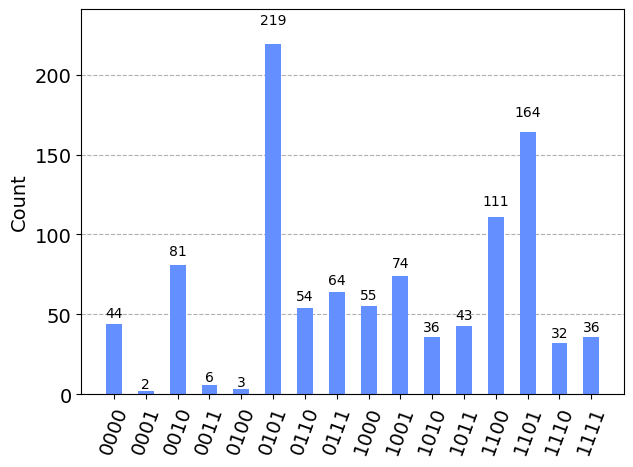

In [10]:
plot_histogram(counts)

{'0001': 0.001953125, '0100': 0.0029296875, '1110': 0.03125, '1101': 0.16015625, '0110': 0.052734375, '1000': 0.0537109375, '1100': 0.1083984375, '1001': 0.072265625, '0101': 0.2138671875, '1111': 0.03515625, '0010': 0.0791015625, '0000': 0.04296875, '1010': 0.03515625, '1011': 0.0419921875, '0111': 0.0625, '0011': 0.005859375}


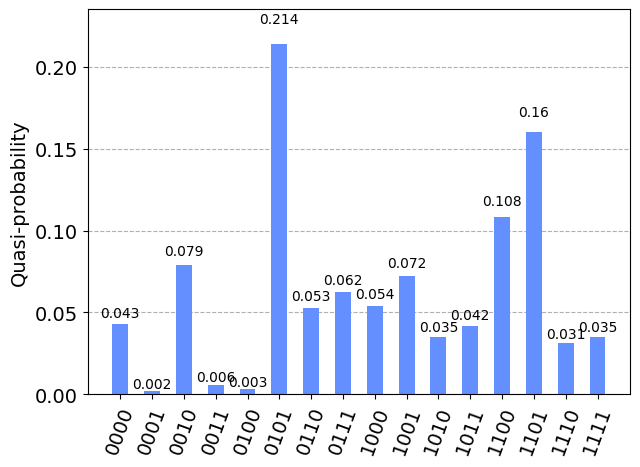

In [11]:
# Calculate probabilities
probs = {v: count/shots for v, count in counts.items()}
print(probs)
plot_histogram(probs)

## Load data (Classical!)

In [12]:
with open('data.csv', newline='') as csvfile:
    data = list(csv.reader(csvfile, delimiter=',', quoting=csv.QUOTE_NONNUMERIC))

One data_row contains:

In [13]:
data_row = data[0]
print(data_row)

[0.2617993877991494, 3.141592653589793, 2.0943951023931953, 1.3089969389957472, 0.0, 0.7964358157055925, 0.8313672111312764, 0.0, 0.0, 0.0, 0.804596018735363, 0.9512026302128396, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]


### `data_row[0:4]`
**Representations of the four tables that should be joined** and angle of the encoding rotation gates. These values were created by turning each tablename into an id and mapping them to the interval $[0,\pi]$.

In this case:
``[0.2617993877991494, 3.141592653589793, 2.0943951023931953, 1.3089969389957472]``

### `data_row[4:20]`
**Rewards for the corresponding join orders** calculated from the execution times
The reward is defined as 
$$\frac{t_\text{best JO}}{t_\text{chosen JO}},$$
where $t$ is the execution time
($0$ for cross joins).

In this case:
``[0.0, 0.7964358157055925, 0.8313672111312764, 0.0, 0.0, 0.0, 0.804596018735363, 0.9512026302128396, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]``


## Create a Quantum Neural Network (Quantum!)

In [14]:
# Select a quantum backend to run the simulation of the quantum circuit
qi = QuantumInstance(qk.Aer.get_backend('aer_simulator_statevector'))

# Create a Quantum Neural Network 
qnn = CircuitQNN(qc, input_params=x, weight_params=params, 
                 quantum_instance = qi)

### Connect to PyTorch (Classical!)

In [15]:
# Initialize random weights in [-pi,pi]
seed = 42 # Seed for random initialization
np.random.seed(seed)
initial_weights = (2*pi*np.random.rand(num_params) - pi)

# Create PyTorch VQC Wrapper
quantum_nn = TorchConnector(qnn, initial_weights)

### Define layer which normalises the prediction (Classical!)

In [16]:
class NormLayer(torch.nn.Module):
    def forward(self, x):
        result = x/x.max()
        return result

# Create a sequential model from the qantum network and the classical norm layer
model = torch.nn.Sequential(quantum_nn, NormLayer())

## Train the model

1. The model can be trained by predicting rewards for a corresponding join order defined in a look-up table.
1. A loss is computed over all predicted rewards and the actual rewards stored in the data.
1. The VQCs parameters get updated via backpropagation with respect to the computed loss.


### Hyperparameters for Training

In [17]:
# Use the adam optimizer    
optimizer = Adam(model.parameters(), lr=0.005)

# Buffers to store the last 10 rewards and losses
rewards = deque(maxlen=10)
losses = deque(maxlen=10)

num_steps = 40 # number of training steps

random.seed(seed) # set seed for data selection

### Run the Training

In [18]:
# save loss and reward for plotting
loss_log, reward_log = [], []

for episode in range(num_steps):

    # Choose a random data entry
    entry = random.choice(data)

    # Predict rewards from the features
    prediction = model(Tensor(entry[0:4])) # Quantum!

    # Choose join order with highest predicted reward
    selected = prediction.argmax()

    # Real reward this selection would give
    current_reward = entry[4+selected]
    
    # Calculate loss as sum of the squared errors
    loss = 0
    for i in range(0, len(prediction)):
        loss += (prediction[i] - entry[4+i])**2

    # Show quality of current episode
    print("Episode: {}, loss: {:.3f}, Reward : {:.3f}".format(episode, loss.item(), current_reward), end="\n")
    
    # Store avg loss and reward over the last 10 steps for plotting 
    rewards.append(current_reward)
    losses.append(loss.item())
    reward_log.append(sum(rewards)/len(rewards))
    loss_log.append(sum(losses)/len(losses))
    
    # Optimize using backpropagation
    optimizer.zero_grad()
    loss.backward()       # calculate gradients (partly Quantum!)
    optimizer.step()      # update parameters


Episode: 0, loss: 3.732, Reward : 0.000
Episode: 1, loss: 5.483, Reward : 0.000
Episode: 2, loss: 3.267, Reward : 0.905
Episode: 3, loss: 3.555, Reward : 0.000
Episode: 4, loss: 5.877, Reward : 0.000
Episode: 5, loss: 3.028, Reward : 0.576
Episode: 6, loss: 3.476, Reward : 0.639
Episode: 7, loss: 3.226, Reward : 0.550
Episode: 8, loss: 3.328, Reward : 0.514
Episode: 9, loss: 3.348, Reward : 0.957
Episode: 10, loss: 3.105, Reward : 0.000
Episode: 11, loss: 5.465, Reward : 0.000
Episode: 12, loss: 2.565, Reward : 1.000
Episode: 13, loss: 4.279, Reward : 0.000
Episode: 14, loss: 3.365, Reward : 0.617
Episode: 15, loss: 3.712, Reward : 0.000
Episode: 16, loss: 3.388, Reward : 0.000
Episode: 17, loss: 3.630, Reward : 0.000
Episode: 18, loss: 2.224, Reward : 0.579
Episode: 19, loss: 3.300, Reward : 0.000
Episode: 20, loss: 2.877, Reward : 0.905
Episode: 21, loss: 3.854, Reward : 0.898
Episode: 22, loss: 4.844, Reward : 0.000
Episode: 23, loss: 4.475, Reward : 0.000
Episode: 24, loss: 2.467, 

## Show Training process

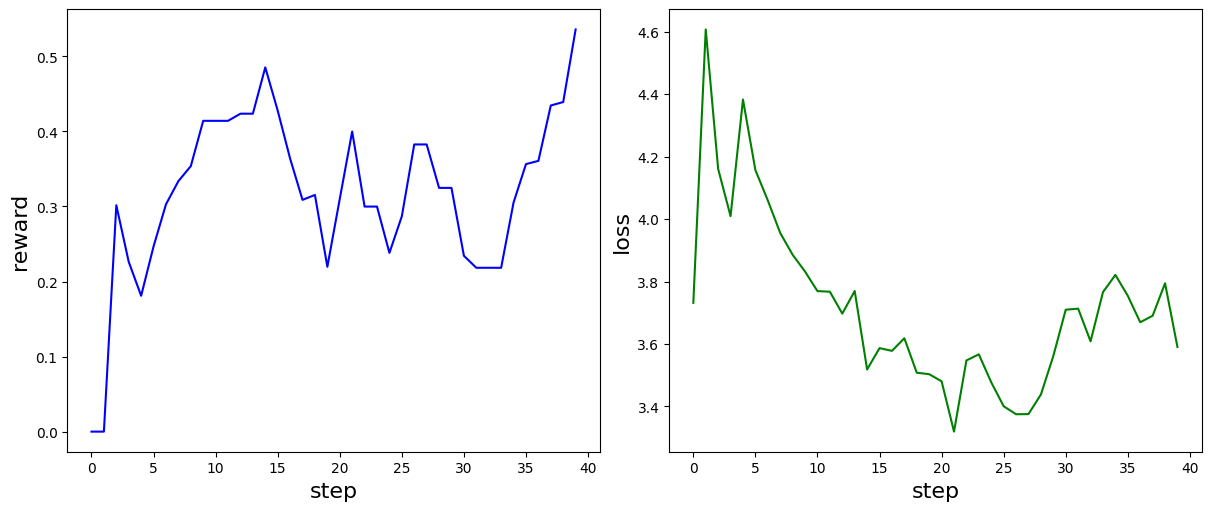

In [19]:
fig, (reward_plot, loss_plot) = plt.subplots(1, 2, figsize=(12, 5), constrained_layout = True)

loss_plot.set_xlabel('step', fontsize = 16)
loss_plot.set_ylabel('loss', fontsize = 16)
loss_plot.plot(range(num_steps), loss_log, color="green")

reward_plot.set_xlabel('step', fontsize = 16)
reward_plot.set_ylabel('reward', fontsize = 16)
reward_plot.plot(range(num_steps), reward_log, color="blue");


## Evaluate the model for all queries

In [20]:
rewardSum = 0
for entry in data:
    # Predict rewards from the features
    prediction = model(Tensor(entry[0:4]))
    # Choose join order with highest predicted reward
    selected = prediction.argmax()
    # Store the real reward this selection would give
    rewardSum += entry[4+selected]

print("Average reward over all queries: {:.3f}".format(rewardSum/len(data)))

Average reward over all queries: 0.383


## Save model parameters

In [21]:
torch.save(model.state_dict(), "vqc.model")